# Check Result Notebook

## Libraries

In [1]:
%cd ..

/root/temp_PoC_TraTra


In [2]:
import logging
import os
import random
import sys

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

sys.path.append('./src')

from utils.arguments import get_configs
from utils.utils import load_model, seed_everything, plot_output
from data_utils.dataloader import get_dataloader
from modules.tratra import TraTra

get_ipython().run_line_magic('matplotlib', 'inline')

## Params

In [3]:
YAML_PATYH = "./configs/exp001.yaml"
GPU_ID = "2"

MODEL_PATH = "./results/exps/tratra.pt"

In [4]:
args = ["--yaml_path", YAML_PATYH, "--gpu_id", GPU_ID, "--notebook_mode"]

In [5]:
logger = logging.getLogger(__name__)

configs = get_configs(logger, args=args)
configs.load_model = MODEL_PATH
device = configs.device

logger.info(f"Loading model path updated to : {configs.load_model}")

seed_everything(configs.seed)

# Prepare Models
model = TraTra(configs).to(device)
model, _ = load_model(model, None, configs.load_model, device)
model = model.eval()

# dataloader
train_loader, valid_loader, test_loader = get_dataloader(configs)

set_device() function cannot found (./results/exps/tratra.pt)


## Prediction

In [6]:
iter_dataloader = iter(test_loader)

In [7]:
# for x, y in tqdm(test_dataloader):
if True:
    x, y, fnames = next(iter_dataloader)
    x = x.float().to(device)
    y = y.float().to(device)

    with torch.no_grad():
        h_maps, coords, pt_states = model(x)

## Visualize Results

### coords

In [8]:
imgs = x.cpu().numpy().transpose(0, 2, 3, 1)

targets = y.cpu().numpy()
pred_coords = coords.cpu().numpy()
pred_pt_states = pt_states.cpu().numpy()

# for now, only mono-stroke
n_pts = pred_pt_states.argmax(axis=1)

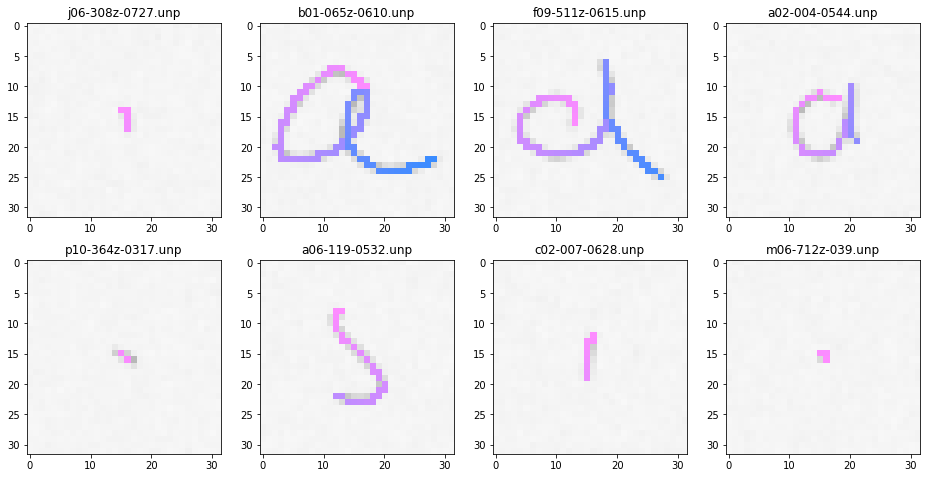

In [9]:
h = 2
w = 4

fig, ax = plt.subplots(h, w, squeeze=False)
fig.set_size_inches(4 * w, 4 * h)

for i in range(h * w):
    fname = os.path.basename(fnames[i])

    savedir = os.path.join(configs.root_save_dir, "notebook_outputs")
    os.makedirs(savedir, exist_ok=True)
    savepath = os.path.join(savedir, fname.replace(".unp", ".png"))
    plot_output(
        imgs[i], 
        pred_coords[i, :n_pts[i]], 
        savepath, 
        color=[255/255, 140/255, 255/255], 
        grad=True,
    )

    image = cv2.imread(savepath)
    ax[i // w, i % w].imshow(image, 'gray')
    ax[i // w, i % w].set_title(fname)

### heatmaps

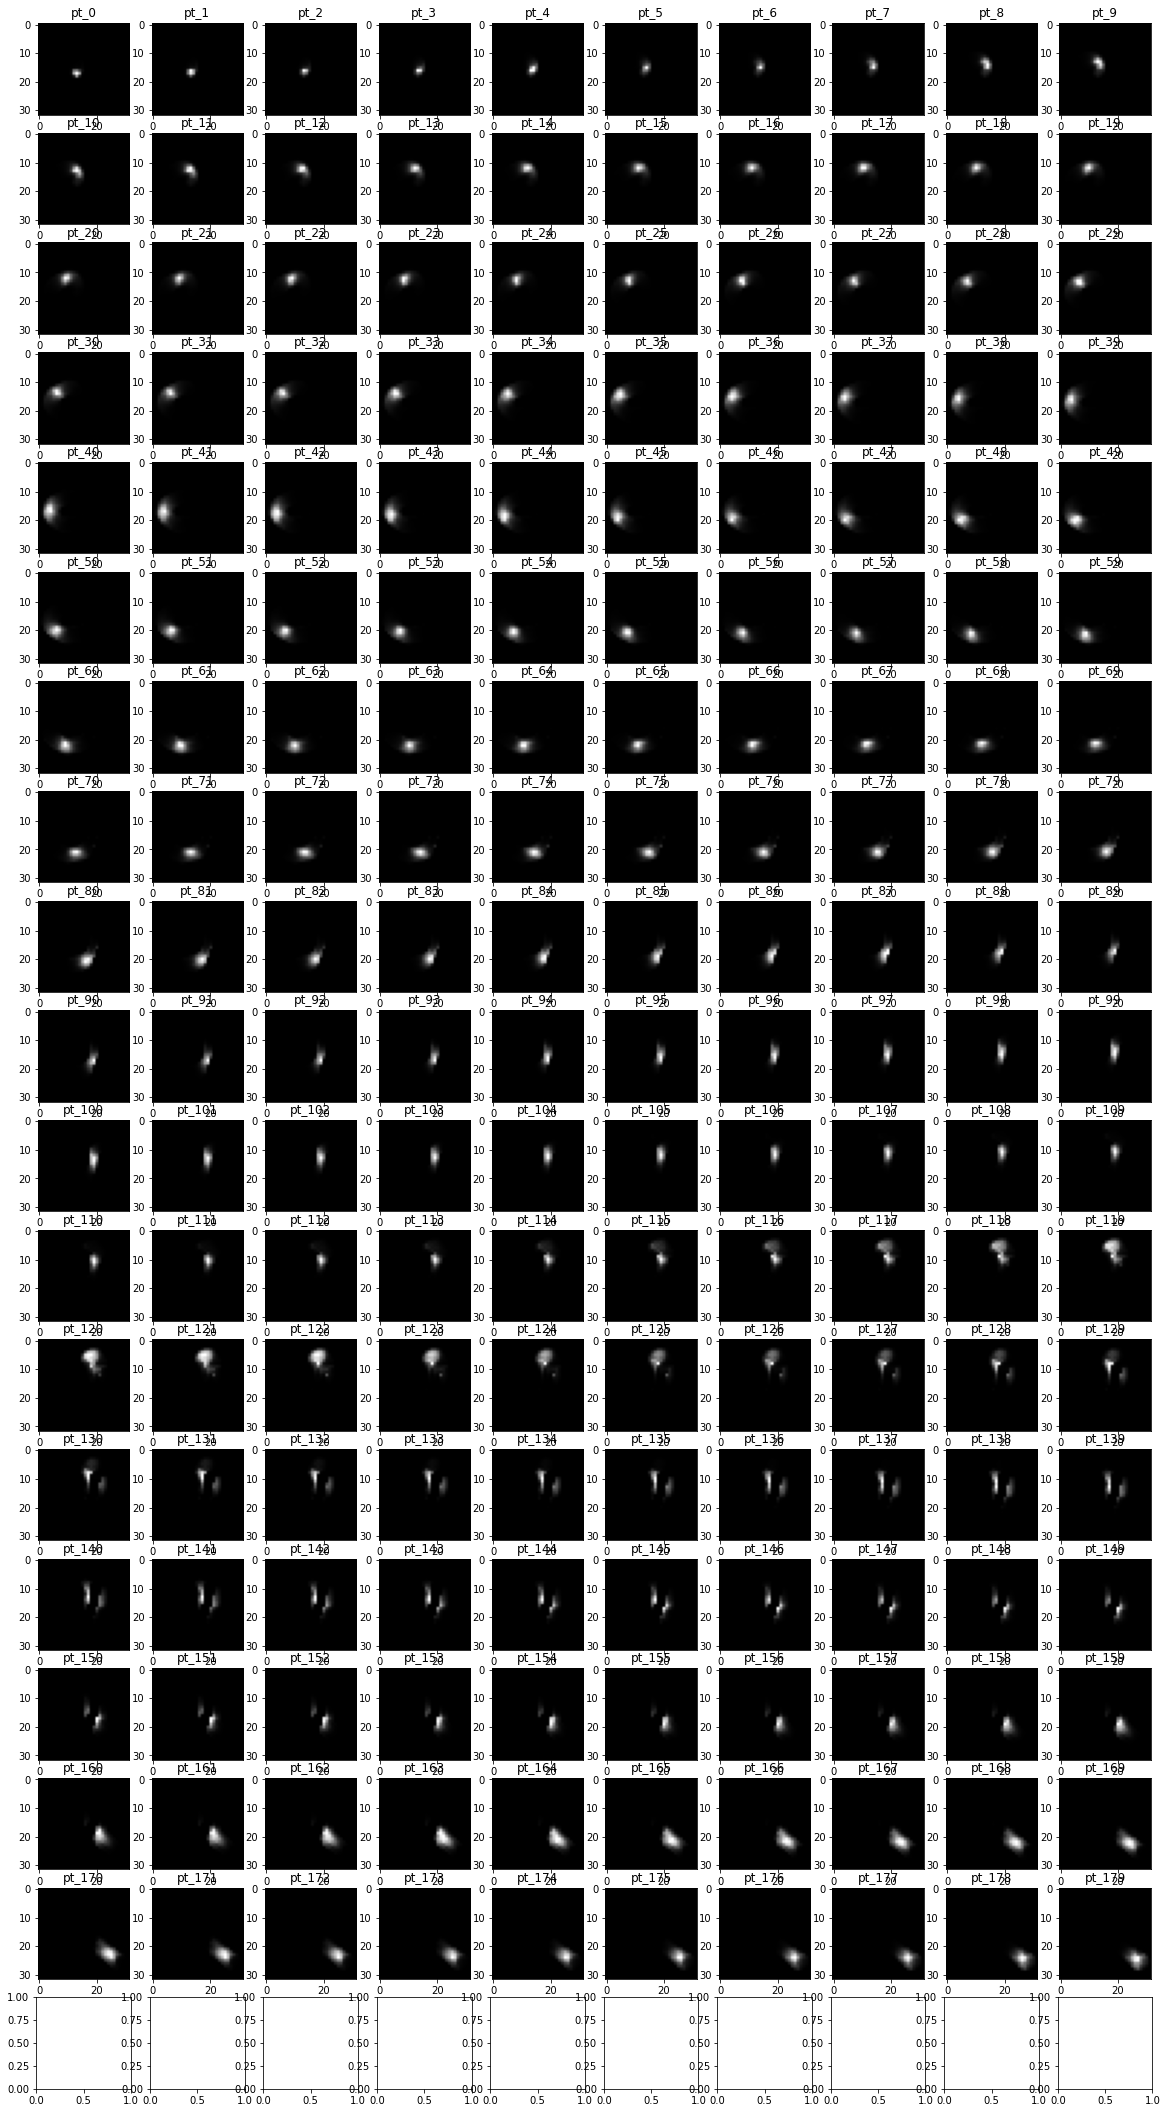

In [10]:
# check heatmaps
j = 2

n_pt = (targets[j, :, 2] >= 0).sum()
heatmap = h_maps.cpu().numpy()[j, :n_pt]

w = 10
h = n_pt // w + 1

fig, ax = plt.subplots(h, w, squeeze=False)
fig.set_size_inches(2 * w, 2 * h)

for i in range(n_pt):
    ax[i // w, i % w].imshow(heatmap[i], 'gray')
    ax[i // w, i % w].set_title(f'pt_{i}')

## Test for sample image

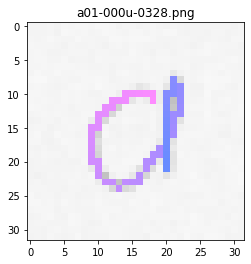

In [11]:
# ## Test for particular image
# img_path = 'input.png'
img_path = "./data/iam_online/gen_iam_256/fig/a01/a01-000/a01-000u-0328.png"

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = Image.fromarray(img.astype(np.uint8))

transform = transforms.Compose([
    transforms.Resize([configs.img_h, configs.img_w]),
    transforms.ToTensor()
])

img = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    h_map, coords, pt_states = model(img)

imgs = img.cpu().numpy().transpose(0, 2, 3, 1)
pred_coords = coords.cpu().numpy()
pred_pt_states = pt_states.cpu().numpy()

# for now, only mono-stroke
n_pts = pred_pt_states.argmax(axis=1)

h = 1
w = 1

fig, ax = plt.subplots(h, w, squeeze=False)
fig.set_size_inches(4 * w, 4 * h)

for i in range(h * w):
    fname = os.path.basename(img_path)

    savedir = os.path.join(configs.root_save_dir, "tmp")
    os.makedirs(savedir, exist_ok=True)
    savepath = os.path.join(savedir, fname)

    plot_output(
        imgs[i],
        pred_coords[i, :n_pts[i]],
        savepath,
        color=[255/255, 140/255, 255/255],
        grad=True,
    )

    image = cv2.imread(savepath)
    ax[i // w, i % w].imshow(image, 'gray')
    ax[i // w, i % w].set_title(fname)